In [1]:
import re

In [1]:
import sys
import os

In [2]:
script_path = "configs/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper.py"

In [3]:
script_path = script_path[:-3]

In [4]:
script_path

'configs/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper'

In [5]:
new_path = script_path.replace("configs", "../results")

In [6]:
new_path

'../results/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper'

In [7]:
with open(new_path + "/test_file.txt", 'w') as f:
    f.write("test")

In [7]:
new_path = os.path.dirname(new_path)

NameError: name 'os' is not defined

In [8]:
import_name = new_path + "/"

In [9]:
script = __import__(import_name)

ModuleNotFoundError: No module named 'results/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper'

In [1]:
import tensorflow as tf

In [16]:
import pennylane as qml
import numpy as np

In [25]:
def variational_layer(wires, params):
    [[qml.RY(params[2*i], wires[i]),
     qml.RZ(params[(i*2)+1], wires[i])] for i in range(len(wires))]

In [26]:
dev = qml.device("default.qubit", wires = 4)
params = [1,2,3,4,5,6,7,8]
@qml.qnode(dev)
def circuit(params):
    variational_layer(range(4), params)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

print(qml.draw(circuit)(params))

0: ──RY(1.00)──RZ(2.00)─┤ ╭<Z@Z>
1: ──RY(3.00)──RZ(4.00)─┤ ╰<Z@Z>
2: ──RY(5.00)──RZ(6.00)─┤       
3: ──RY(7.00)──RZ(8.00)─┤       


In [27]:
def entangling_layer(wires):
    qml.CZ(wires = [0,1])
    qml.CZ(wires = [1,2])
    qml.CZ(wires = [2,3])
    qml.CZ(wires = [3,0])

In [28]:
def data_encoding(wires, data):
    [qml.RX(data[i], wires[i], id = f"x_{i}") for i in range(len(wires))]

In [29]:
dev = qml.device("default.qubit", wires = 4)

num_layers = 2

@qml.qnode(dev)
def schuld_datareup(params, data):
    for l in range(num_layers):
        variational_layer(range(4), params[l])
        entangling_layer(range(4))
        data_encoding(range(4), data)
    variational_layer(range(4), params[num_layers])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [30]:
@qml.qnode(dev)
def basic_datareup(params, data):
    for l in range(num_layers-1):
        data_encoding(range(4), data)
        variational_layer(range(4), params[l])
        entangling_layer(range(4))
    data_encoding(range(4), data)
    variational_layer(range(4), params[num_layers-1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [31]:
data = np.random.uniform(-0.05,0.05, size=4)
params_schuld =[[np.random.uniform(0, np.pi) for i in range(8)] for j in range(num_layers + 1)]
params_basic = params_schuld[:-1]

In [32]:
print(qml.draw(schuld_datareup)(params_schuld, data))

0: ──RY(2.67)──RZ(3.01)─╭●───────╭Z──RX(-0.03)──RY(2.48)──RZ(0.81)─╭●───────╭Z──RX(-0.03)──RY(1.18)
1: ──RY(1.65)──RZ(2.98)─╰Z─╭●────│───RX(0.02)───RY(0.20)──RZ(1.81)─╰Z─╭●────│───RX(0.02)───RY(0.20)
2: ──RY(0.83)──RZ(0.07)────╰Z─╭●─│───RX(0.05)───RY(3.05)──RZ(2.79)────╰Z─╭●─│───RX(0.05)───RY(1.42)
3: ──RY(1.50)──RZ(2.05)───────╰Z─╰●──RX(-0.05)──RY(1.14)──RZ(1.87)───────╰Z─╰●──RX(-0.05)──RY(0.87)

───RZ(0.80)─┤ ╭<Z@Z>
───RZ(1.43)─┤ ╰<Z@Z>
───RZ(2.36)─┤       
───RZ(1.38)─┤       


In [33]:
print(qml.draw(basic_datareup)(params_basic, data))

0: ──RX(-0.03)──RY(2.67)──RZ(3.01)─╭●───────╭Z──RX(-0.03)──RY(2.48)──RZ(0.81)─┤ ╭<Z@Z>
1: ──RX(0.02)───RY(1.65)──RZ(2.98)─╰Z─╭●────│───RX(0.02)───RY(0.20)──RZ(1.81)─┤ ╰<Z@Z>
2: ──RX(0.05)───RY(0.83)──RZ(0.07)────╰Z─╭●─│───RX(0.05)───RY(3.05)──RZ(2.79)─┤       
3: ──RX(-0.05)──RY(1.50)──RZ(2.05)───────╰Z─╰●──RX(-0.05)──RY(1.14)──RZ(1.87)─┤       


In [34]:
from pennylane.fourier import coefficients, circuit_spectrum
freqs_schuld = circuit_spectrum(schuld_datareup)(params_schuld, data)
freqs_basic = circuit_spectrum(basic_datareup)(params_basic, data)

In [35]:
for k,v in freqs_schuld.items():
    print(k, ":", v)

for k,v in freqs_basic.items():
    print(k, ":", v)

x_0 : [-2.0, -1.0, 0, 1.0, 2.0]
x_1 : [-2.0, -1.0, 0, 1.0, 2.0]
x_2 : [-2.0, -1.0, 0, 1.0, 2.0]
x_3 : [-2.0, -1.0, 0, 1.0, 2.0]
x_0 : [-2.0, -1.0, 0, 1.0, 2.0]
x_1 : [-2.0, -1.0, 0, 1.0, 2.0]
x_2 : [-2.0, -1.0, 0, 1.0, 2.0]
x_3 : [-2.0, -1.0, 0, 1.0, 2.0]


In [36]:
from functools import partial
partial_schuld_circuit = partial(schuld_datareup, params_schuld)
partial_basic_circuit = partial(basic_datareup, params_basic)

coeffs_schuld = coefficients(partial_schuld_circuit, 4, 2)
coeffs_basic = coefficients(partial_basic_circuit, 4, 2)

In [37]:
coeffs_schuld

array([[[[-3.36432758e-03+0.00000000e+00j,
           8.50737979e-04-5.41607078e-04j,
           4.31876757e-18-2.85188539e-19j,
           4.31876757e-18+2.85188539e-19j,
           8.50737979e-04+5.41607078e-04j],
         [-1.82399564e-03+1.87960614e-02j,
          -1.03925408e-02+6.10105621e-04j,
          -1.56725183e-18-1.46886714e-18j,
           1.12225948e-18-4.23017702e-18j,
          -5.31058819e-03-1.41866471e-03j],
         [ 4.14945855e-19+4.68791672e-18j,
          -4.79095930e-18-1.85754190e-18j,
           1.29645644e-18+7.01387146e-19j,
          -3.95245578e-18+1.81748529e-18j,
           9.26342336e-20+2.65690248e-18j],
         [ 4.14945855e-19-4.68791672e-18j,
           9.26342336e-20-2.65690248e-18j,
          -3.95245578e-18-1.81748529e-18j,
           1.29645644e-18-7.01387146e-19j,
          -4.79095930e-18+1.85754190e-18j],
         [-1.82399564e-03-1.87960614e-02j,
          -5.31058819e-03+1.41866471e-03j,
           1.12225948e-18+4.23017702e-18j,
       

In [38]:
coeffs_basic

array([[[[-1.34623405e-02+0.00000000e+00j,
          -9.14823772e-18+1.57860477e-18j,
          -1.33235437e-18-4.77360464e-18j,
          -1.33235437e-18+4.77360464e-18j,
          -9.14823772e-18-1.57860477e-18j],
         [-5.68434189e-18+3.67516605e-19j,
          -4.81774388e-05+2.10538287e-18j,
           4.24813056e-18+2.87313830e-19j,
           1.07732945e-17+5.02003162e-18j,
          -4.81774388e-05-6.52788120e-18j],
         [-4.81559237e-19+8.69184417e-19j,
           6.53115608e-20+1.80312353e-18j,
           1.25572550e-18+1.84913837e-18j,
          -1.06744204e-18+4.24135606e-19j,
          -4.62277708e-18-1.58879995e-18j],
         [-4.81559237e-19-8.69184417e-19j,
          -4.62277708e-18+1.58879995e-18j,
          -1.06744204e-18-4.24135606e-19j,
           1.25572550e-18-1.84913837e-18j,
           6.53115608e-20-1.80312353e-18j],
         [-5.68434189e-18-3.67516605e-19j,
          -4.81774388e-05+6.52788120e-18j,
           1.07732945e-17-5.02003162e-18j,
       

In [39]:
from pennylane.fourier.visualize import *
import matplotlib.pyplot as plt

array([<AxesSubplot: ylabel='real'>, <AxesSubplot: ylabel='imag'>],
      dtype=object)

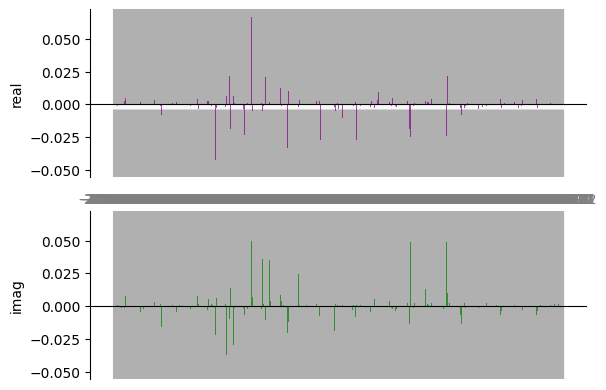

In [41]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True) # Set up the axes
bar(coeffs_schuld, 4, ax)

array([<AxesSubplot: ylabel='real'>, <AxesSubplot: ylabel='imag'>],
      dtype=object)

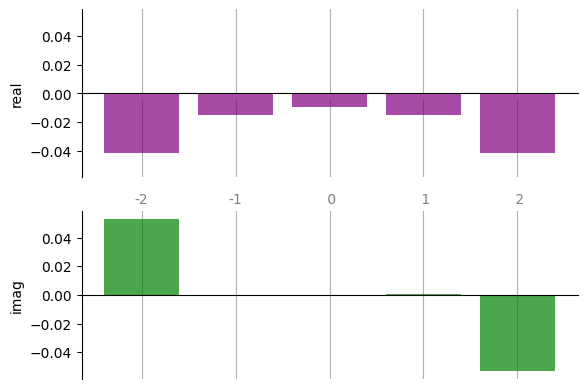

In [209]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True) # Set up the axes
bar(coeffs_basic, 1, ax)

In [98]:
@qml.qnode(dev)
def simple_circuit(x):
    qml.RX(x[0], wires=0)
    qml.RY(x[0], wires=1)
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliZ(0))

In [99]:
coeffs = coefficients(simple_circuit, 1, 2)

In [291]:
dev = qml.device("default.qubit", wires = 1)

@qml.qnode(dev)
def simple_circuit(params, data):
    qml.RX(params[0], wires=0)
    qml.RY(data[0], wires = 0, id = "x")
    qml.RX(params[1], wires = 0)
    qml.RY(data[1], wires = 0, id = "x")
    qml.RX(params[2], wires = 0)
    return qml.expval(qml.PauliZ(0))

In [294]:
data = [0,1]
params = [0.5,0.3,0.8]

In [295]:
simple_freqs = circuit_spectrum(simple_circuit)(params, data)

In [296]:
for k,v in simple_freqs.items():
    print(k, ":", v)

x : [-2.0, -1.0, 0, 1.0, 2.0]


In [297]:
from functools import partial

In [301]:
partial_circuit = partial(simple_circuit, params)
coeffs = coefficients(partial_circuit,2,1,lowpass_filter=True)

In [302]:
coeffs

array([[-0.32855821+0.j, -0.04935468+0.j, -0.04935468+0.j],
       [-0.09302078+0.j,  0.29888181+0.j, -0.00682701+0.j],
       [-0.09302078+0.j, -0.00682701+0.j,  0.29888181+0.j]])

In [287]:
def fourier_coefficients(f, K):
    """
    Computes the first 2*K+1 Fourier coefficients of a 2*pi periodic function.
    """
    n_coeffs = 2 * K + 1
    t = np.linspace(0, 2 * np.pi, n_coeffs, endpoint=False)
    y = np.fft.rfft(f(t)) / t.size
    return y

In [288]:
def f(x):
    return np.array([simple_circuit(params,x_) for x_ in x])

In [289]:
coeffs = fourier_coefficients(f, 1)

In [290]:
coeffs

array([-0.14167993+0.00000000e+00j,  0.41919332-1.28197512e-16j])

In [1]:
import pennylane as qml
import numpy as np

In [168]:
params = [np.random.uniform(0, np.pi) for i in range(6)]

In [181]:
dev = qml.device("default.qubit", wires = 2)

@qml.qnode(dev)
def circuit(params):
    qml.RY(params[0], wires = 0)
    qml.RY(params[1], wires = 1)
    qml.RX(params[2], wires = 0)
    qml.RX(params[3], wires = 1)
    qml.RZ(params[4], wires = 0)
    qml.RZ(params[5], wires = 1)
    qml.CNOT(wires = [0,1])
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

In [182]:
results = circuit(params)
results = results[0] * results[1]
results

tensor(0.00106099, requires_grad=True)

In [183]:
@qml.qnode(dev)
def circuit(params):
    qml.RY(params[0], wires = 0)
    qml.RY(params[1], wires = 1)
    qml.RX(params[2], wires = 0)
    qml.RX(params[3], wires = 1)
    qml.RZ(params[4], wires = 0)
    qml.RZ(params[5], wires = 1)
    #qml.CNOT(wires = [0,1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [184]:
result = circuit(params)
result

tensor(-0.03021677, requires_grad=True)

In [1]:
from fourier_analysis.pennylane_operations import *
from fourier_analysis.pennylane_fourier import *
import pennylane as qml
import numpy as np

In [2]:
operations = QMLOperations()

In [3]:
dev = qml.device("default.qubit", wires = 4)

@qml.qnode(dev)
def circuit(param):
    operations.skolik_entangling_layer(range(4))
    qml.RX(param, wires = 0)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [4]:
print(qml.draw(circuit)(5))

0: ─╭●───────╭●──RX(5.00)─┤ ╭<Z@Z>
1: ─╰Z─╭●────│────────────┤ ╰<Z@Z>
2: ────╰Z─╭●─│────────────┤       
3: ───────╰Z─╰Z───────────┤       


In [5]:
def operations():
    qml.Hadamard(wires = 0)

In [6]:
def circuit(param):
    operations()
    qml.RX(param, wires = 0)
    return qml.sample(qml.PauliZ(0))

In [7]:
dev = qml.device("default.qubit", wires = 1, shots = 5)
qnode = qml.QNode(circuit, dev)


In [8]:
print(qml.draw(qnode)(5))

0: ──H──RX(5.00)─┤  Sample[Z]


In [1]:
from fourier_analysis.pennylane_operations import *
from fourier_analysis.pennylane_fourier import *
import pennylane as qml
import numpy as np

In [2]:
num_qubits = 4
num_layers = 2
circuit_arch = "skolik"
data_reuploading = "schuld"
measurement = "ZZ"
weights = np.random.uniform(0, np.pi, size = (num_layers + 1, num_qubits*2))
data = np.random.uniform(-0.05, 0.05)

fourier_analysis = Fourier_Analysis(num_qubits, num_layers, circuit_arch, data_reuploading, measurement, weights, data)

In [3]:
fourier_analysis.draw_circuit()

0: ──RY(0.52)──RZ(0.69)─╭●───────╭●──RX(-0.04)──RY(1.77)──RZ(2.99)─╭●───────╭●──RX(-0.04)──RY(1.01)
1: ──RY(0.60)──RZ(2.20)─╰Z─╭●────│───RX(-0.04)──RY(0.36)──RZ(0.84)─╰Z─╭●────│───RX(-0.04)──RY(2.09)
2: ──RY(1.65)──RZ(0.48)────╰Z─╭●─│───RX(-0.04)──RY(2.06)──RZ(3.07)────╰Z─╭●─│───RX(-0.04)──RY(0.40)
3: ──RY(2.19)──RZ(1.77)───────╰Z─╰Z──RX(-0.04)──RY(2.19)──RZ(1.66)───────╰Z─╰Z──RX(-0.04)──RY(0.04)

───RZ(2.94)─┤ ╭<Z@Z>
───RZ(1.39)─┤ ╰<Z@Z>
───RZ(1.04)─┤       
───RZ(2.85)─┤       


In [4]:
freqs = fourier_analysis.circuit_spectrum()

for k,v in freqs.items():
    print(k, ":", v)

x_0 : [-2.0, -1.0, 0, 1.0, 2.0]
x_1 : [-2.0, -1.0, 0, 1.0, 2.0]
x_2 : [-2.0, -1.0, 0, 1.0, 2.0]
x_3 : [-2.0, -1.0, 0, 1.0, 2.0]


In [5]:
coeffs = fourier_analysis.fourier_coefficients()

1


IndexError: index 1 is out of bounds for axis 0 with size 1

In [14]:
coeffs

array([-0.16289115+0.j        , -0.02834013+0.00514463j,
       -0.06372178-0.13927614j, -0.06372178+0.13927614j,
       -0.02834013-0.00514463j])

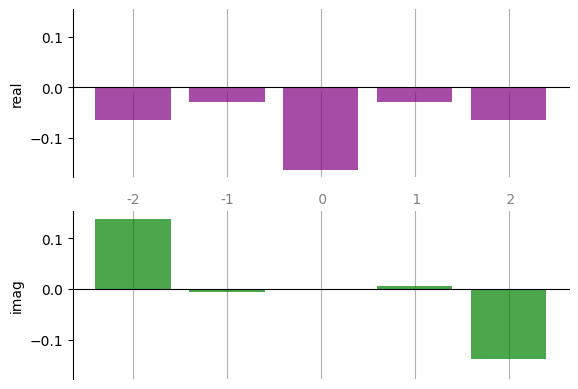

In [15]:
fourier_analysis.plot_coefficients()

In [41]:
def variational_layer(wires, params):
    [[qml.RY(params[2*i], wires[i]),
     qml.RZ(params[(i*2)+1], wires[i])] for i in range(len(wires))]
    
def entangling_layer(wires):
    qml.CZ(wires = [0,1])
    qml.CZ(wires = [1,2])
    qml.CZ(wires = [2,3])
    qml.CZ(wires = [3,0])

def data_encoding_1d(wires, data):
    [qml.RX(data, wires[i], id = f"x_{i}") for i in range(len(wires))]

def data_encoding_nd(wires, data):
    [qml.RX(data[i], wires[i], id = f"x_{i}") for i in range(len(wires))]

def data_encoding(wires, data):
    print(type(data))
    if type(data) == int or type(data) == float:
        data_encoding_1d(wires, data)
    else:
        data_encoding_nd(wires, data)

In [42]:
def schuld_datareup(params, data):
    for l in range(num_layers):
        variational_layer(range(4), params[l])
        entangling_layer(range(4))
        data_encoding(range(4), data)
    variational_layer(range(4), params[num_layers])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [43]:
dev = qml.device("default.qubit", wires = 4)
qnode = qml.QNode(schuld_datareup, dev)

In [44]:
num_qubits = 4
num_layers = 2
circuit_arch = "skolik"
data_reuploading = "schuld"
measurement = "ZZ"
weights = np.random.uniform(0, np.pi, size = (num_layers+1, num_qubits*2))
data = np.random.uniform(-0.05, 0.05)

In [45]:
freqs = circuit_spectrum(qnode)(weights, data)

<class 'float'>
<class 'float'>


In [46]:
freqs

{'x_0': [-2.0, -1.0, 0, 1.0, 2.0],
 'x_1': [-2.0, -1.0, 0, 1.0, 2.0],
 'x_2': [-2.0, -1.0, 0, 1.0, 2.0],
 'x_3': [-2.0, -1.0, 0, 1.0, 2.0]}

In [47]:
from functools import partial

In [48]:
partial_circuit = partial(qnode, weights)
coeffs = coefficients(partial_circuit,1,2)

<class 'numpy.ndarray'>


IndexError: index 1 is out of bounds for axis 0 with size 1